In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from scipy import spatial
import itertools

from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer


from collections import Counter

import dateparser
from time import time
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import string

from spellchecker import SpellChecker

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel

/Users/nmm/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Loading

In [2]:
# load the dataset into a Pandas DataFrame and parse the date
articles = pd.read_csv("../Data/all_articles.csv", parse_dates=['Date'], date_parser=dateparser.parse)
n_before = len(articles) # number of articles in the DF
# print 5 radom rows
articles.sample(5)

,Unnamed: 0,Unnamed: 0.1,Article Title,Journal,Date,Url,Text,Unnamed: 0.1.1
88,88,8,Un/une chef de section Direction de la s...,La Liberté,1995-01-14,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,Un / une chef de section Direction de la sect...,NaN
8888,6070,70,2 LA LIBERTE JEUDI 11 JUILLET 2002 La me...,La Liberté,2002-07-11,https://www.e-newspaperarchives.ch/?a=d&d=LLE2...,2 LA LIBERTE JEUDI 11 JUILLET 2002 La mer Adr...,10.0
14105,2427,427,Hôtel-Restaurant de Sîviez,Le Nouvelliste,1983-12-23,https://www.e-newspaperarchives.ch/?a=d&d=NVE1...,qui sera prise a ce propos par le ministre Ni...,7.0
16482,4804,804,Pistes contestées de Crans-Montana Balad...,La Liberté,1986-02-14,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,Pistes contestées de Crans-Montana Balade des...,4.0
8056,5238,238,Venise sauvée des algues,Le Nouvelliste,1991-12-13,https://www.e-newspaperarchives.ch/?a=d&d=NVE1...,Venise sauvée des algues Les algues géantes ...,18.0


In [3]:
for col in articles.columns:
    if "Unnamed" in col:
        articles.drop(col, axis=1, inplace=True)
        
articles.sample()

,Article Title,Journal,Date,Url,Text
5827,Pluie ae rees sur le Knone Le conseil de...,Le Nouvelliste,2004-04-08,https://www.e-newspaperarchives.ch/?a=d&d=NVE2...,Pluie ae rees sur le Knone Le conseil de pilo...


In [4]:
# drop rows (=articles) with missing informations
articles = articles.dropna().reset_index()
print("{0} rows with NaN dropped, {1} articles remaining in the DF.".format(n_before-len(articles), len(articles)))

47 rows with NaN dropped, 22631 articles remaining in the DF.


In [5]:
# drop duplicate rows
articles = articles.drop_duplicates(subset=['Text'])
print("{0} rows remaining in the dataset after dropping duplicates.".format(len(articles)))

22577 rows remaining in the dataset after dropping duplicates.


# NLP preprocessing

In [6]:
STOP_FR = stopwords.words("french")
STOP_FR += ["comme", "tout", "aussi", "sans", "si", "selon"]
STOP_FR += ["de", "du", "des"] # added bc of tfidf on epochs

PUNCTUATION = [punc for punc in string.punctuation]
PUNCTUATION += ["›", "__", "’", "‘", "...", "„", "¦"]

In [7]:
# remove punctuation and lower 
cleaned_text = articles["Text"].apply(lambda article: article.translate(str.maketrans('', '', string.punctuation)).lower())

In [8]:
def tokenize_list_articles(list_articles):
    """ tokenize iterable object and remove some pre-defined values """
    tokenized_articles = [word_tokenize(article) for article in list_articles]
    tokenized_articles = [[token.lower() for token in article 
                           if not (token.lower() in STOP_FR+PUNCTUATION
                           or token.isnumeric()
                           or len(token) < 3)
                          ]
                         for article in tokenized_articles]
    return tokenized_articles

In [9]:
%%time 
texts_articles = list(articles["Text"].values)
tokenized_articles = tokenize_list_articles(list(cleaned_text))
# add a column in the DF:
articles["tokens"] = tokenized_articles

CPU times: user 52.3 s, sys: 573 ms, total: 52.9 s
Wall time: 52.9 s


# LDA

In [19]:
def assess_lda(list_ntopics
               , tokenized_texts
               , nmin = 5
               , nmax = 0.9
               , random_state = 42
               , passes = 10
               , alpha = 0.01
               , eta = 0.01
               , nb_it = 500
               , eval_every = None
              ):

    dictionary_LDA = corpora.Dictionary(tokenized_texts)
    dictionary_LDA.filter_extremes(no_below=nmin, no_above=nmax)

    corpus = [dictionary_LDA.doc2bow(article) for article in tokenized_texts]
    model_tfidf = models.TfidfModel(corpus)
    corpus_tfidf = model_tfidf[corpus]
    
    C_vs = np.zeros(len(list_ntopics))
    C_umasss = np.zeros(len(list_ntopics))

    multi_n_topics=list(itertools.chain(*[[n]*n for n in list_ntopics]))
    topic_id=list(itertools.chain(*[list(np.arange(n)) for n in list_ntopics]))
    lda_df = pd.DataFrame(index=[multi_n_topics, topic_id])
    lda_df["top_words"] = ['']*len(lda_df)

    for i, n_topics in tqdm(enumerate(list_ntopics)):
        curr_lda_model = models.LdaModel(corpus_tfidf
                                         , num_topics=n_topics
                                         , id2word=dictionary_LDA
                                         , passes=passes
                                         , alpha=[alpha]*n_topics
                                         , eta=[eta]*len(dictionary_LDA.keys())
                                         , eval_every=eval_every
                                         , random_state=random_state
                                        )
        
        for j,topic in curr_lda_model.show_topics(formatted=True, num_topics=n_topics, num_words=25):
            lda_df.loc[n_topics,j]["top_words"]=topic

        C_vs[i] = CoherenceModel(model=curr_lda_model
                                 , texts=tokenized_texts
                                 , dictionary=dictionary_LDA
                                 , coherence='c_v'
                                ).get_coherence()

        C_umasss[i] = CoherenceModel(model=curr_lda_model
                                     , corpus=corpus_tfidf
                                     , coherence='u_mass'
                                    ).get_coherence()
        
    return lda_df, C_vs, C_umasss

In [20]:
def plot_cv_cumass(ntopics, cvs, cumasss):
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots(figsize=(10,7))
    # make a plot
    ax.plot(ntopics, cvs, color="red", marker="o")
    # set x-axis label
    ax.set_xlabel("Number of topics",fontsize=14)
    # set y-axis label
    ax.set_ylabel(r"$C_v$",color="red",fontsize=14)
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(ntopics, cumasss,color="blue",marker="o")
    ax2.set_ylabel(r"$C_{umass}$",color="blue",fontsize=14)
    plt.show()

In [21]:
N_min = 5
perc_max = 0.9

N_topics = np.arange(5,50,2, dtype=int)

lda_df, C_vs, C_umasss = assess_lda(list_ntopics = N_topics
                                    , tokenized_texts = tokenized_articles
                                    , nmin = N_min
                                    , nmax = perc_max
                                    , random_state = 42
                                    , passes = 10
                                    , alpha = 0.01
                                    , eta = 0.01
                                    , nb_it = 500
                                    , eval_every = None
                                   )

23it [1:21:34, 212.79s/it]


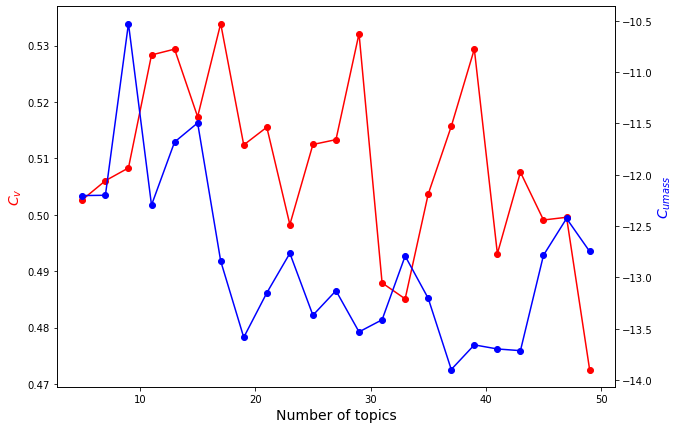

In [23]:
plot_cv_cumass(N_topics, C_vs, C_umasss)

In [32]:
lda_df.to_csv("lda_5_50_2_5_09.csv")

In [31]:
with pd.option_context('display.max_colwidth', None):
    display(lda_df.loc[11])

,top_words
0,"0.020*""canons"" + 0.019*""neige"" + 0.014*""remontées"" + 0.013*""télésiège"" + 0.012*""mécaniques"" + 0.011*""enneigement"" + 0.011*""grimentz"" + 0.010*""diablerets"" + 0.009*""cabane"" + 0.007*""chalets"" + 0.007*""skieurs"" + 0.007*""artificiel"" + 0.007*""chamonix"" + 0.006*""saintluc"" + 0.006*""vercorin"" + 0.006*""zinal"" + 0.006*""week"" + 0.006*""station"" + 0.006*""cheyres"" + 0.005*""glacier"" + 0.005*""téléverbier"" + 0.005*""aoste"" + 0.005*""cadehl"" + 0.005*""brélaz"" + 0.005*""anniviers"""
1,"0.029*""nlfa"" + 0.018*""sociauxdémocrates"" + 0.015*""rplp"" + 0.014*""eveline"" + 0.012*""widmerschlumpf"" + 0.010*""bilatérales"" + 0.009*""iris"" + 0.008*""suède"" + 0.008*""hockey"" + 0.007*""fûts"" + 0.007*""grisonne"" + 0.007*""haury"" + 0.006*""campagnols"" + 0.006*""jacquesandré"" + 0.005*""lake"" + 0.005*""tél"" + 0.005*""city"" + 0.005*""navire"" + 0.005*""garage"" + 0.005*""kenya"" + 0.005*""park"" + 0.005*""adg"" + 0.004*""vainqueurs"" + 0.004*""lpp"" + 0.004*""clavien"""
2,"0.007*""parti"" + 0.007*""conseil"" + 0.005*""gauche"" + 0.004*""national"" + 0.004*""voix"" + 0.004*""droite"" + 0.004*""partis"" + 0.004*""socialistes"" + 0.004*""verts"" + 0.004*""socialiste"" + 0.004*""sièges"" + 0.004*""linitiative"" + 0.004*""majorité"" + 0.003*""élections"" + 0.003*""pdc"" + 0.003*""radicaux"" + 0.003*""parlement"" + 0.003*""etats"" + 0.003*""initiative"" + 0.003*""detat"" + 0.003*""fédéral"" + 0.003*""candidats"" + 0.003*""gouvernement"" + 0.003*""libéraux"" + 0.003*""peuple"""
3,"0.006*""coalition"" + 0.005*""cdu"" + 0.005*""chirac"" + 0.004*""pes"" + 0.004*""municipales"" + 0.003*""eos"" + 0.003*""strauss"" + 0.003*""hydrorhône"" + 0.003*""jospin"" + 0.003*""réacteur"" + 0.003*""motion"" + 0.003*""blocher"" + 0.003*""gerhard"" + 0.003*""rocard"" + 0.002*""crime"" + 0.002*""bâleville"" + 0.002*""électriciens"" + 0.002*""réélu"" + 0.002*""galmiz"" + 0.002*""kosovo"" + 0.002*""francophones"" + 0.002*""lat"" + 0.002*""fusion"" + 0.002*""laccord"" + 0.002*""csu"""
4,"0.023*""rothenthurm"" + 0.011*""denner"" + 0.011*""fsc"" + 0.009*""darmes"" + 0.008*""dmf"" + 0.007*""transgénique"" + 0.007*""plutonium"" + 0.006*""ulm"" + 0.006*""last"" + 0.005*""hubacher"" + 0.005*""transgéniques"" + 0.005*""soja"" + 0.005*""cherbourg"" + 0.005*""monsanto"" + 0.005*""sri"" + 0.004*""maru"" + 0.004*""langenberger"" + 0.004*""brest"" + 0.004*""neuchlenanschwilen"" + 0.004*""profitez"" + 0.004*""pnr"" + 0.004*""badewurtemberg"" + 0.004*""forest"" + 0.003*""lirak"" + 0.003*""leasing"""
5,"0.059*""golf"" + 0.019*""grimisuat"" + 0.011*""jeûne"" + 0.009*""tsamarau"" + 0.007*""plongeurs"" + 0.007*""défrichement"" + 0.006*""anzère"" + 0.006*""toxicomanes"" + 0.006*""roumains"" + 0.005*""pneus"" + 0.005*""chanvre"" + 0.004*""conseu"" + 0.004*""fee"" + 0.004*""serbie"" + 0.004*""vogel"" + 0.004*""rallye"" + 0.004*""milosevic"" + 0.003*""unesco"" + 0.003*""petitduc"" + 0.003*""gottlieb"" + 0.003*""toyota"" + 0.002*""gwh"" + 0.002*""treyvaux"" + 0.002*""piccard"" + 0.002*""coca"""
6,"0.023*""nostra"" + 0.022*""giscard"" + 0.018*""aqua"" + 0.016*""destaing"" + 0.015*""motocross"" + 0.010*""honda"" + 0.010*""pef"" + 0.008*""félix"" + 0.008*""pétrolier"" + 0.007*""daqua"" + 0.007*""motards"" + 0.007*""roggo"" + 0.007*""francfort"" + 0.006*""troislacs"" + 0.005*""pétroliers"" + 0.005*""fioul"" + 0.005*""hybride"" + 0.005*""die"" + 0.005*""psv"" + 0.005*""chappaz"" + 0.004*""volvo"" + 0.004*""boff"" + 0.004*""leonardo"" + 0.004*""réparation"" + 0.004*""valdez"""
7,"0.003*""cio"" + 0.003*""jeux"" + 0.003*""olympique"" + 0.003*""rad"" + 0.003*""locataires"" + 0.003*""olympiques"" + 0.002*""cleusondixence"" + 0.002*""coalition"" + 0.002*""salquenen"" + 0.002*""pacifistes"" + 0.002*""rudolf"" + 0.002*""fasel"" + 0.002*""manche"" + 0.002*""affirment"" + 0.002*""larrêté"" + 0.002*""kaspar"" + 0.002*""lyon"" + 0.002*""contribuables"" + 0.002*""exclu"" + 0.002*""barras"" + 0.002*""critiqué"" + 0.002*""épreuves"" + 0.002*""victime"" + 0.002*""ra

In [34]:
N_min = 5
perc_max = 0.9

dictionary_LDA = corpora.Dictionary(tokenized_articles)
dictionary_LDA.filter_extremes(no_below=N_min, no_above=perc_max)

corpus = [dictionary_LDA.doc2bow(article) for article in tokenized_articles]

In [35]:
num_opt = 5
%time lda_model = models.LdaModel(corpus, num_topics=num_opt, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_opt, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

for i,topic in lda_model.show_topics(formatted=True, num_topics=num_opt, num_words=10):
    print(str(i)+": "+ topic)
    print()

CPU times: user 34.6 s, sys: 155 ms, total: 34.7 s
Wall time: 34.7 s
0: 0.013*"conseil" + 0.010*"parti" + 0.008*"plus" + 0.007*"deux" + 0.007*"contre" + 0.006*"suisse" + 0.006*"fédéral" + 0.006*"gauche" + 0.006*"politique" + 0.006*"national"

1: 0.009*"projet" + 0.006*"cette" + 0.005*"plus" + 0.005*"valais" + 0.004*"canton" + 0.004*"deux" + 0.004*"écologistes" + 0.004*"protection" + 0.004*"entre" + 0.004*"commune"

2: 0.012*"plus" + 0.007*"bien" + 0.006*"cette" + 0.006*"fait" + 0.004*"faire" + 0.004*"tous" + 0.004*"ans" + 0.004*"monde" + 0.004*"quil" + 0.003*"écologistes"

3: 0.012*"plus" + 0.006*"nucléaire" + 0.006*"suisse" + 0.005*"cette" + 0.004*"être" + 0.004*"lénergie" + 0.004*"millions" + 0.004*"moins" + 0.003*"francs" + 0.003*"deux"

4: 0.013*"plus" + 0.011*"suisse" + 0.006*"pays" + 0.005*"cette" + 0.005*"être" + 0.004*"environnement" + 0.004*"protection" + 0.004*"produits" + 0.003*"agriculture" + 0.003*"production"



In [100]:
nums_topics = np.arange(3,25,1)
C_vs = np.zeros(len(nums_topics))
C_umasss = np.zeros(len(nums_topics))

multi_n_topics=list(itertools.chain(*[[n]*n for n in nums_topics]))
topic_id=list(itertools.chain(*[list(np.arange(n)) for n in nums_topics]))
arrays = [multi_n_topics, topic_id]

lda_df = pd.DataFrame(index=arrays)
lda_df["top_words"] = ['']*len(lda_df)

lda_df

top_words
3  0           
   1           
   2           
4  0           
   1           
...         ...
24 19          
   20          
   21          
   22          
   23          

[297 rows x 1 columns]

In [101]:
for i, n_topics in tqdm(enumerate(nums_topics)):
    curr_lda_model = models.LdaModel(corpus
                                     , num_topics=n_topics
                                     , id2word=dictionary_LDA
                                     , passes=4
                                     , alpha=[0.01]*n_topics
                                     , eta=[0.01]*len(dictionary_LDA.keys())
                                    )
    
    for j,topic in curr_lda_model.show_topics(formatted=True, num_topics=n_topics, num_words=25):
        lda_df.loc[i+np.min(nums_topics),j]=topic
    
    
    C_vs[i] = CoherenceModel(model=curr_lda_model
                             , texts=tokenized_articles
                             , dictionary=dictionary_LDA
                             , coherence='c_v'
                            ).get_coherence()
    
    C_umasss[i] = CoherenceModel(model=curr_lda_model
                                 , corpus=corpus
                                 , coherence='u_mass'
                                ).get_coherence()

22it [20:35, 56.17s/it]


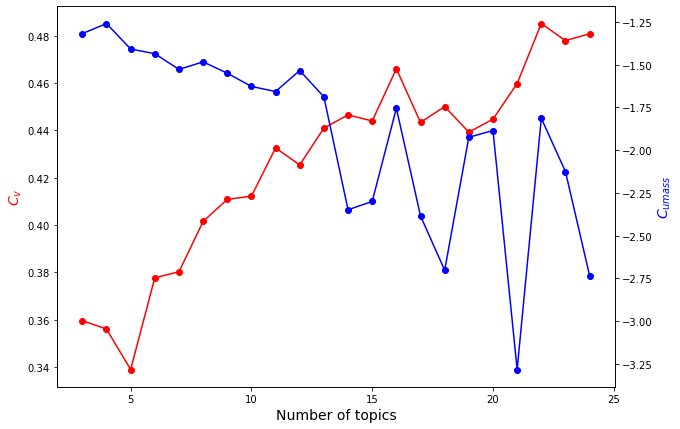

In [102]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(10,7))
# make a plot
ax.plot(nums_topics, C_vs, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Number of topics",fontsize=14)
# set y-axis label
ax.set_ylabel(r"$C_v$",color="red",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(nums_topics, C_umasss,color="blue",marker="o")
ax2.set_ylabel(r"$C_{umass}$",color="blue",fontsize=14)
plt.show()